# **WildFace Recognition** 

### **1. Imports**

In [1]:
# Libraries imports
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# modules imports
from finalproject.attack import nes_optimize, create_query_fn, run_attack_suite
from finalproject.data_loader import load_lfw_data
from finalproject.data import load_lfw, create_splits, NumpyFaceDataset
from finalproject.defense import defend_postprocess
from finalproject.detector import QueryPatternDetector, extract_window_features, train_detector, calibrate_threshold
from finalproject.features import extract_features
from finalproject.metrics import compute_ssim, compute_psnr
from finalproject.models import SmallCNN, ConvEncoder, ConvDecoder, train_autoencoder
from finalproject.train import train_classifier
from finalproject.utils import set_seed
from finalproject.visualization import visualize_classifier_predictions, visualize_attack_results, visualize_real_vs_reconstructed

# Set seed for reproducibility
set_seed(42)

### **2. Data loader**

In [2]:
# Load the dataset
loader = load_lfw_data()

# Access the data
print("Dataset shapes:")
print(f"Images: {loader.images.shape}")
print(f"Data: {loader.data.shape}")
print(f"Target: {loader.target.shape}")
print(f"\nTarget names: {[str(name) for name in loader.target_names]}")

# Get class distribution
distribution = loader.get_class_distribution()
print("\nClass distribution:")
for name, count in distribution.items():
    print(f"  {name}: {count} images")

Dataset will be saved to: ../dataset/
✓ Dataset directory already exists
  Location: d:\Rutgers\PAI\final_project_PAI\final-project-Malav786\dataset\lfw_home
Dataset shapes:
Images: (1288, 50, 37)
Data: (1288, 1850)
Target: (1288,)

Target names: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']

Class distribution:
  Ariel Sharon: 77 images
  Colin Powell: 236 images
  Donald Rumsfeld: 121 images
  George W Bush: 530 images
  Gerhard Schroeder: 109 images
  Hugo Chavez: 71 images
  Tony Blair: 144 images


### **3. Dataset Showcase**

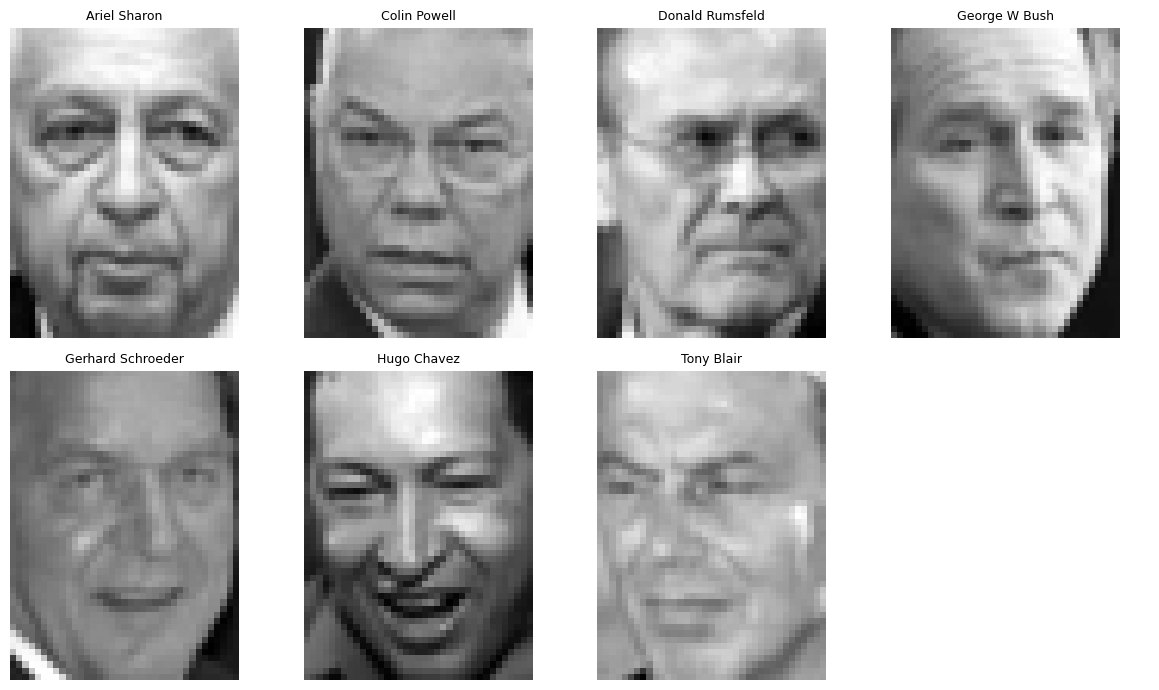

In [3]:
loader.show_distinct_people(n_cols=4, seed=42)

### **4. Dataset Split**

In [4]:
# Use the existing loader instance to get normalized data
X, y, target_names = load_lfw(loader=loader)

X_train, y_train, X_val, y_val, X_test, y_test = create_splits(X, y, test_size=0.2, val_size=0.1, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print("classes:", len(target_names))

(901, 50, 37) (129, 50, 37) (258, 50, 37)
classes: 7


In [5]:
# Verify split sizes
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 901
Validation samples: 129
Test samples: 258


### **5. CNN Training**


In [6]:
# Create transform for images
transform = transforms.Compose([
    transforms.ToTensor()  # Converts PIL Image to tensor and adds channel dimension
])

# Create labeled datasets for supervised learning
train_ds = NumpyFaceDataset(X_train, y=y_train, transform=transform)
val_ds = NumpyFaceDataset(X_val, y=y_val, transform=transform)
test_ds = NumpyFaceDataset(X_test, y=y_test, transform=transform)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Create and train the CNN classifier
print("\nTraining supervised CNN classifier...")
print("=" * 60)
model = SmallCNN(in_channels=1, num_classes=len(target_names))
model = train_classifier(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    device=device,
    epochs=30,
    batch_size=64
)


Using device: cpu

Training supervised CNN classifier...


d:\Rutgers\PAI\final_project_PAI\final-project-Malav786\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | train_loss 1.7167 | val_loss 1.8765 | val_acc 0.4109 *
Epoch 2/30 | train_loss 1.6160 | val_loss 1.7679 | val_acc 0.4109 *
Epoch 3/30 | train_loss 1.4099 | val_loss 1.7681 | val_acc 0.5116 
Epoch 4/30 | train_loss 1.3285 | val_loss 1.3770 | val_acc 0.5581 *
Epoch 5/30 | train_loss 1.1888 | val_loss 1.2408 | val_acc 0.5969 *
Epoch 6/30 | train_loss 1.0564 | val_loss 1.0709 | val_acc 0.7054 *
Epoch 7/30 | train_loss 0.9984 | val_loss 1.0550 | val_acc 0.6667 *
Epoch 8/30 | train_loss 0.9281 | val_loss 0.8824 | val_acc 0.7364 *
Epoch 9/30 | train_loss 0.8421 | val_loss 0.7571 | val_acc 0.7287 *
Epoch 10/30 | train_loss 0.7699 | val_loss 0.5801 | val_acc 0.7597 *
Epoch 11/30 | train_loss 0.7065 | val_loss 0.6738 | val_acc 0.7829 
Epoch 12/30 | train_loss 0.6365 | val_loss 0.5186 | val_acc 0.8217 *
Epoch 13/30 | train_loss 0.5975 | val_loss 0.4451 | val_acc 0.8140 *
Epoch 14/30 | train_loss 0.5597 | val_loss 0.4452 | val_acc 0.8372 
Epoch 15/30 | train_loss 0.5383 | val_loss 0.3

### **6. Test Set Evaluation**


In [7]:
# Evaluate on test set
print("\n" + "=" * 60)
print("Evaluating on test set...")
model.eval()
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
test_correct = 0
test_total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        test_correct += (preds == yb).sum().item()
        test_total += yb.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(yb.cpu().numpy())

test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[str(name) for name in target_names]))
print("=" * 60)



Evaluating on test set...

Test Accuracy: 0.9070 (90.70%)

Test Set Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.73      0.85        15
     Colin Powell       0.90      0.98      0.94        47
  Donald Rumsfeld       0.82      0.92      0.87        25
    George W Bush       0.91      0.97      0.94       106
Gerhard Schroeder       0.93      0.59      0.72        22
      Hugo Chavez       0.93      0.93      0.93        14
       Tony Blair       0.93      0.86      0.89        29

         accuracy                           0.91       258
        macro avg       0.92      0.86      0.88       258
     weighted avg       0.91      0.91      0.90       258



### **7. Classifier Predictions**


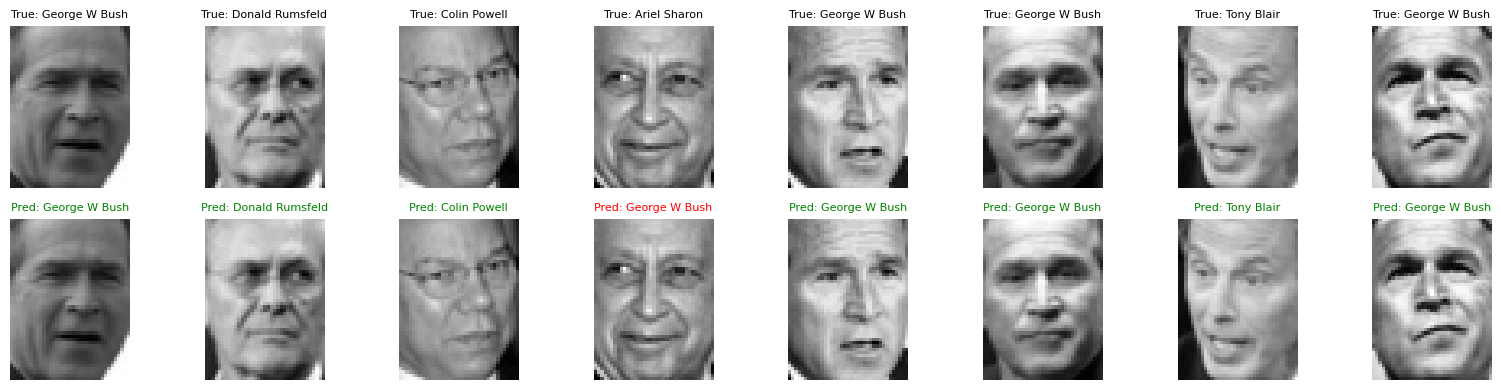

Sample batch accuracy: 87.50%


In [8]:
# Visualize some test predictions
visualize_classifier_predictions(model, test_ds, target_names, device=device, num_images=8)


### **8. Autoencoder Training**


In [9]:
# Create datasets for autoencoder (no labels needed)
train_ds_ae = NumpyFaceDataset(X_train, y=None, transform=transform)
val_ds_ae = NumpyFaceDataset(X_val, y=None, transform=transform)

# Create encoder and decoder
encoder = ConvEncoder(latent_dim=64, in_channels=1)
decoder = ConvDecoder(latent_dim=64, out_channels=1)

# Train the autoencoder
print("\nTraining autoencoder...")
print("=" * 60)
encoder, decoder = train_autoencoder(
    encoder=encoder,
    decoder=decoder,
    train_ds=train_ds_ae,
    val_ds=val_ds_ae,
    device=device,
    epochs=50,  # Increased from 30
)



Training autoencoder...
AE epoch 1/50: train_loss 0.029077 (PSNR 15.72dB, acc 23.15%), val_loss 0.031054 (PSNR 15.32dB, acc 20.77%) *
AE epoch 2/50: train_loss 0.028670 (PSNR 15.78dB, acc 23.39%), val_loss 0.026843 (PSNR 15.95dB, acc 22.51%) *
AE epoch 3/50: train_loss 0.024802 (PSNR 16.44dB, acc 26.39%), val_loss 0.022925 (PSNR 16.66dB, acc 24.59%) *
AE epoch 4/50: train_loss 0.024152 (PSNR 16.65dB, acc 27.84%), val_loss 0.021356 (PSNR 16.98dB, acc 25.74%) *
AE epoch 5/50: train_loss 0.022209 (PSNR 16.95dB, acc 28.85%), val_loss 0.020270 (PSNR 17.22dB, acc 26.70%) *
AE epoch 6/50: train_loss 0.022887 (PSNR 16.88dB, acc 28.64%), val_loss 0.020109 (PSNR 17.26dB, acc 26.55%) *
AE epoch 7/50: train_loss 0.021774 (PSNR 17.03dB, acc 29.01%), val_loss 0.019240 (PSNR 17.47dB, acc 28.15%) *
AE epoch 8/50: train_loss 0.021520 (PSNR 17.10dB, acc 29.75%), val_loss 0.018645 (PSNR 17.61dB, acc 29.79%) *
AE epoch 9/50: train_loss 0.020590 (PSNR 17.27dB, acc 31.11%), val_loss 0.018100 (PSNR 17.72dB,

### **9. Autoencoder Feature Extraction and Classification**


In [10]:
# Extract features using the trained encoder from train and validation sets
train_features, train_labels = extract_features(encoder, train_ds, device=device)
val_features, val_labels = extract_features(encoder, val_ds, device=device)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

print(f"Train features shape: {train_features.shape}")
print(f"Val features shape: {val_features.shape}")

# Train a classifier on the extracted features
print("\nTraining SVM classifier on autoencoder features...")
classifier = SVC(kernel='linear', C=10, gamma='scale', class_weight='balanced')
classifier.fit(train_features, train_labels)

# Evaluate
val_pred = classifier.predict(val_features)
ae_val_acc = accuracy_score(val_labels, val_pred)

print(f"\nClassification accuracy using autoencoder features: {ae_val_acc:.4f} ({ae_val_acc*100:.2f}%)")
print("\nClassification Report (Autoencoder + SVM):")
print(classification_report(val_labels, val_pred, target_names=[str(name) for name in target_names], zero_division=0))


Train features shape: (901, 64)
Val features shape: (129, 64)

Training SVM classifier on autoencoder features...

Classification accuracy using autoencoder features: 0.7209 (72.09%)

Classification Report (Autoencoder + SVM):
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.75      0.57         8
     Colin Powell       0.70      0.79      0.75        24
  Donald Rumsfeld       0.64      0.58      0.61        12
    George W Bush       0.87      0.77      0.82        53
Gerhard Schroeder       0.46      0.55      0.50        11
      Hugo Chavez       0.80      0.57      0.67         7
       Tony Blair       0.77      0.71      0.74        14

         accuracy                           0.72       129
        macro avg       0.67      0.68      0.66       129
     weighted avg       0.74      0.72      0.73       129



### **10. Performance Comparison**


PERFORMANCE COMPARISON
Supervised CNN (Test Set):     0.9070 (90.70%)
Autoencoder + SVM (Val Set):   0.7209 (72.09%)
Performance Difference:        0.1860 (25.8% relative)


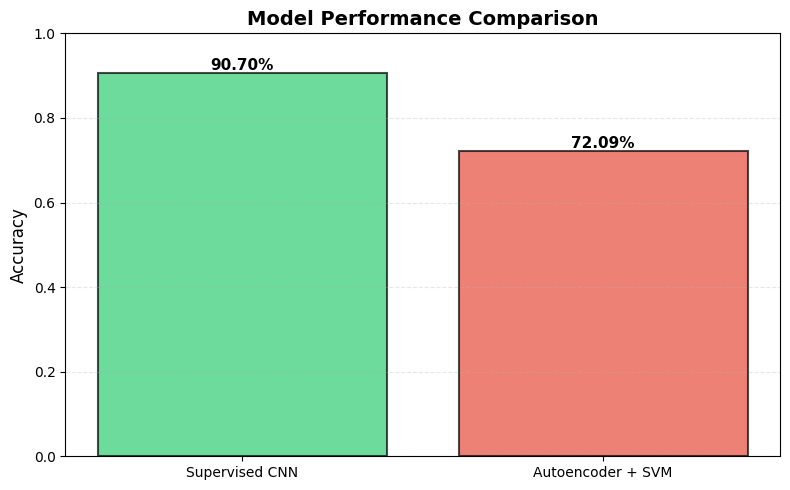

In [11]:
# Compare performances
print("=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)
print(f"Supervised CNN (Test Set):     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Autoencoder + SVM (Val Set):   {ae_val_acc:.4f} ({ae_val_acc*100:.2f}%)")
print(f"Performance Difference:        {test_acc - ae_val_acc:.4f} ({((test_acc - ae_val_acc) / ae_val_acc * 100):.1f}% relative)")
print("=" * 60)

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
models = ['Supervised CNN', 'Autoencoder + SVM']
accuracies = [test_acc, ae_val_acc]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### **11. Model Inversion Attack using NES**

Although the autoencoder achieves lower classification accuracy (68.22%) compared to the supervised CNN (85.66%), it is not intended to serve as a predictive model. Instead, it is used as a reconstruction mechanism in a model inversion attack. The CNN acts as the victim classifier, while the autoencoder demonstrates how sensitive facial information can be reconstructed from model outputs, highlighting a privacy vulnerability rather than a performance limitation.

**Attack Overview:**
- **Black-box attack**: Attacker only has access to classifier's softmax outputs (probabilities)
- **NES optimization**: Uses Natural Evolution Strategy to optimize latent vector without gradients
- **Goal**: Reconstruct images that maximize target class probability
- **Method**: Iteratively update latent vector z by querying the classifier and using NES gradient estimate

In [12]:
# Create query function for the victim classifier
query_fn = create_query_fn(model, device=device, num_classes=len(target_names))

# Test query function with a sample image
print("Testing query function...")
sample_img = X_test[1]  # Get a sample image
probs = query_fn(sample_img)
print(f"Sample image probabilities: {probs}")
print(f"Predicted class: {target_names[np.argmax(probs)]}")
print(f"Confidence: {probs.max():.4f}")

Testing query function...
Sample image probabilities: [3.0437668e-04 9.6922004e-01 4.8895145e-04 2.3284728e-04 7.2380825e-04
 2.6699344e-02 2.3307132e-03]
Predicted class: Colin Powell
Confidence: 0.9692


confidence this high is common with softmax models and does not guarantee the prediction is correct (softmax can be overconfident), but since your CNN accuracy is ~85%, it’s usually reliable.

### **12. Run NES Attack for Different Target Classes**

We perform a black-box model inversion attack using NES to optimize latent representations that decode into facial images maximizing the victim classifier’s confidence for a target identity.


In [13]:
# Attack hyperparameters (realistic black-box NES setup)
nes_sigma = 0.2        # Start with higher noise for exploration
nes_pop = 50           # Population size (samples per iteration)
nes_iters = 800        # Maximum optimization iterations
latent_dim = 64        # Latent dimension of autoencoder

min_iters = 100        # Minimum NES iterations before early stopping
latent_reg = 5e-4      # Light latent regularization for realism
lr = 0.05              # Slightly lower LR for smoother convergence

# Run attack for a few target classes
target_classes = [0, 1, 3]  # Ariel Sharon, Colin Powell, George W Bush

# Run attack suite
attack_results = run_attack_suite(
    decoder=decoder,
    query_fn=query_fn,
    target_names=target_names,
    target_classes=target_classes,
    device=device,
    nes_sigma=nes_sigma,
    nes_pop=nes_pop,
    nes_iters=nes_iters,
    latent_dim=latent_dim,
    lr=lr,
    latent_reg=latent_reg,
    sigma_anneal=True,
    min_iters=min_iters
)


Attack Configuration:
  Population size: 50
  Noise scale (sigma): 0.2
  Iterations: 800
  Latent dimension: 64
  Total queries per attack (upper bound): 40000

Attacking target class: Ariel Sharon (index 0)


NES Optimization:  12%|█▎        | 100/800 [00:22<02:35,  4.50it/s]


Early stopping at iter 101

Final confidence for Ariel Sharon
Prediction: Ariel Sharon
Total queries used: 5050

Attacking target class: Colin Powell (index 1)


NES Optimization:  12%|█▎        | 100/800 [00:22<02:39,  4.39it/s]


Early stopping at iter 101

Final confidence for Colin Powell
Prediction: Colin Powell
Total queries used: 5050

Attacking target class: George W Bush (index 3)


NES Optimization:  12%|█▎        | 100/800 [00:21<02:30,  4.65it/s]

Early stopping at iter 101

Final confidence for George W Bush
Prediction: George W Bush
Total queries used: 5050


### **13. Visualize Attack Results**


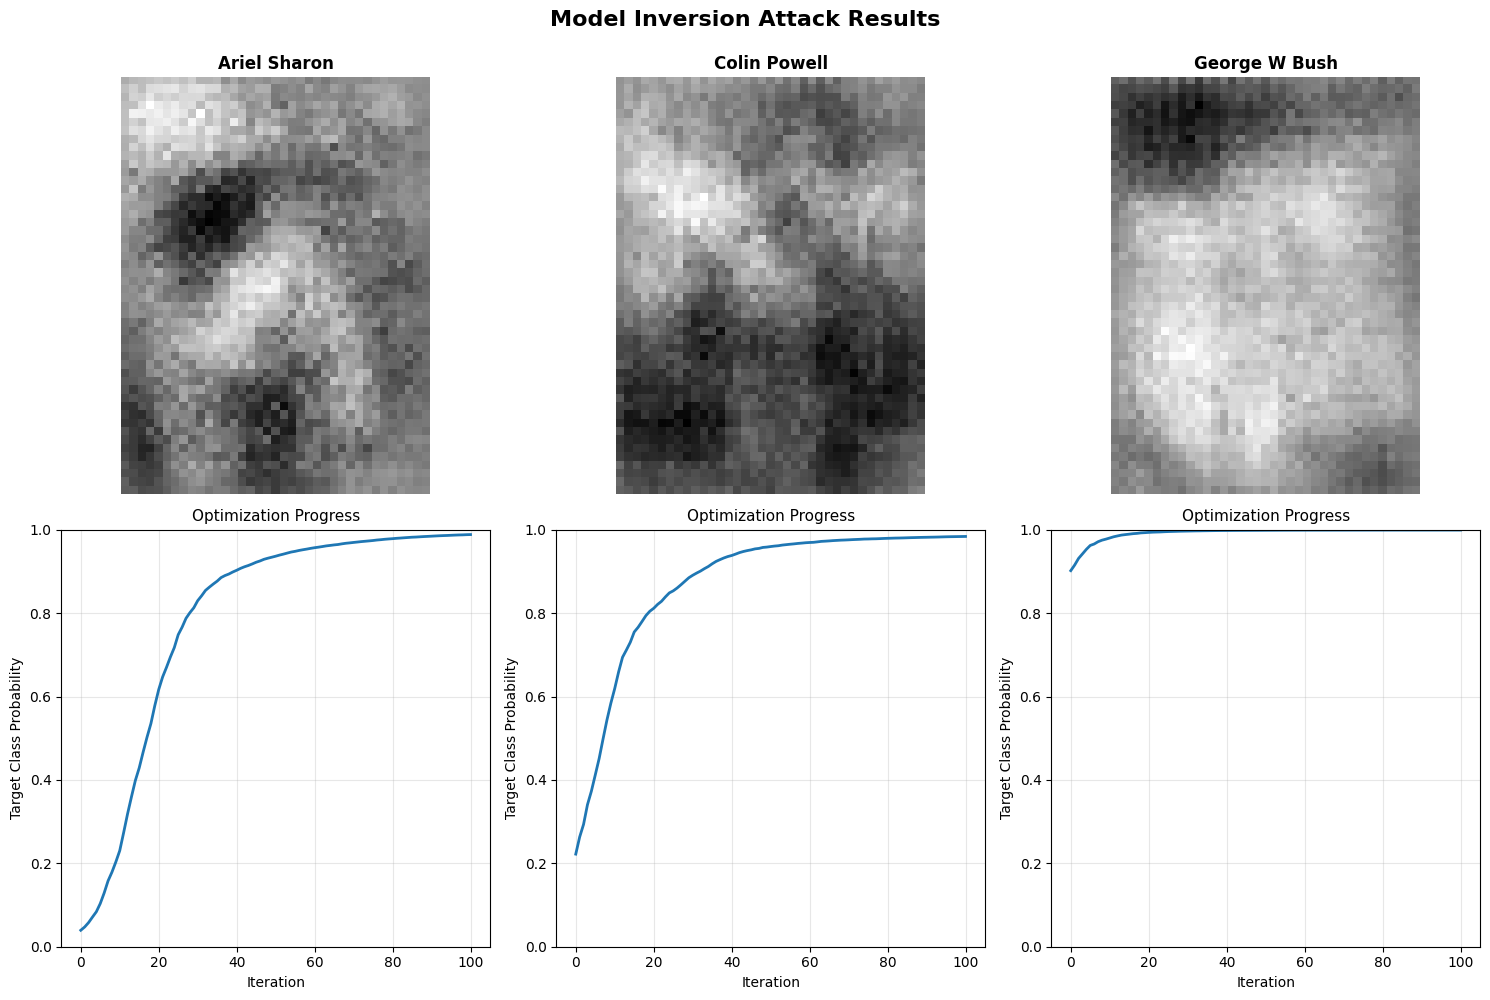


ATTACK SUMMARY
Ariel Sharon         | Queries: 5050
Colin Powell         | Queries: 5050
George W Bush        | Queries: 5050


In [14]:
# Visualize reconstructed images and optimization history
visualize_attack_results(attack_results, nes_pop, target_names)


### **14. Compare Real vs Reconstructed Images**

This section evaluates whether the classifier can distinguish between real and reconstructed images. We will:
1. Select real test images from the target classes
2. Mix them with reconstructed images from the attack
3. Evaluate classifier accuracy on the mixed set
4. Compare accuracy on real images only vs mixed set
5. Visualize real vs reconstructed side-by-side


In [15]:
# Select real test images from target classes
target_class_indices = list(attack_results.keys())
n_samples_per_class = 10  # Number of real images per class

real_images = []
real_labels = []
reconstructed_images = []
reconstructed_labels = []

# Collect real test images
for class_idx in target_class_indices:
    # Find indices of test samples for this class
    test_indices = np.where(y_test == class_idx)[0]
    
    # Randomly select n_samples_per_class images
    if len(test_indices) >= n_samples_per_class:
        selected_indices = np.random.choice(test_indices, n_samples_per_class, replace=False)
    else:
        selected_indices = test_indices
    
    # Get the images and labels
    for idx in selected_indices:
        img = X_test[idx]
        real_images.append(img)
        real_labels.append(class_idx)
    
    # Add reconstructed image
    reconstructed_images.append(attack_results[class_idx]['best_image'])
    reconstructed_labels.append(class_idx)

# Convert to numpy arrays
real_images = np.array(real_images)
real_labels = np.array(real_labels)
reconstructed_images = np.array(reconstructed_images)
reconstructed_labels = np.array(reconstructed_labels)

print(f"Real images collected: {len(real_images)}")
print(f"Reconstructed images: {len(reconstructed_images)}")
print(f"Total mixed set size: {len(real_images) + len(reconstructed_images)}")


Real images collected: 30
Reconstructed images: 3
Total mixed set size: 33


In [16]:
# Evaluate classifier on real images only
model.eval()
real_predictions = []
real_confidences = []

with torch.no_grad():
    for img in real_images:
        # Convert to tensor and add batch dimension
        img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0).to(device)
        
        # Get prediction
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        confidence = probs[0, pred].cpu().numpy()
        
        real_predictions.append(pred)
        real_confidences.append(confidence)

real_predictions = np.array(real_predictions)
real_confidences = np.array(real_confidences)
real_accuracy = accuracy_score(real_labels, real_predictions)

print(f"Accuracy on real images only: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")


Accuracy on real images only: 0.8667 (86.67%)


In [17]:
# Evaluate classifier on reconstructed images
reconstructed_predictions = []
reconstructed_confidences = []

with torch.no_grad():
    for img in reconstructed_images:
        # Convert to tensor and add batch dimension
        img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0).to(device)
        
        # Get prediction
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        confidence = probs[0, pred].cpu().numpy()
        
        reconstructed_predictions.append(pred)
        reconstructed_confidences.append(confidence)

reconstructed_predictions = np.array(reconstructed_predictions)
reconstructed_confidences = np.array(reconstructed_confidences)
reconstructed_accuracy = accuracy_score(reconstructed_labels, reconstructed_predictions)

print(f"Accuracy on reconstructed images: {reconstructed_accuracy:.4f} ({reconstructed_accuracy*100:.2f}%)")
print(f"\nReconstructed image predictions:")
for i, class_idx in enumerate(target_class_indices):
    class_name = target_names[class_idx]
    pred_name = target_names[reconstructed_predictions[i]]
    print(f"  {class_name:20s} -> {pred_name:20s} (confidence: {reconstructed_confidences[i]:.4f})")


Accuracy on reconstructed images: 1.0000 (100.00%)

Reconstructed image predictions:
  Ariel Sharon         -> Ariel Sharon         (confidence: 0.9883)
  Colin Powell         -> Colin Powell         (confidence: 0.9838)
  George W Bush        -> George W Bush        (confidence: 0.9991)


### Note on High Confidence Despite Abstract Appearance

We noticed that the reconstructed images appear abstract or noisy to human observers, yet the classifier assigns them very high confidence (99%+). This behavior is expected and highlights an important property of the attack:

1. **Feature Mismatch**  
   The classifier relies on learned discriminative features that do not necessarily align with human visual perception. The inversion attack optimizes these internal feature representations rather than visual realism.

2. **Attack Success**  
   The high confidence indicates that the attack successfully identifies inputs that strongly activate the target class features, even when the resulting images do not resemble realistic human faces.

3. **Privacy Risk**  
   This demonstrates that sensitive identity-related information can be inferred from a model’s decision boundary, even when reconstructed inputs appear abstract, highlighting a meaningful privacy vulnerability.


In [18]:
# Create mixed dataset (real + reconstructed)
mixed_images = np.concatenate([real_images, reconstructed_images], axis=0)
mixed_labels = np.concatenate([real_labels, reconstructed_labels], axis=0)

# Evaluate classifier on mixed set
mixed_predictions = []
mixed_confidences = []

with torch.no_grad():
    for img in mixed_images:
        # Convert to tensor and add batch dimension
        img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0).to(device)
        
        # Get prediction
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        confidence = probs[0, pred].cpu().numpy()
        
        mixed_predictions.append(pred)
        mixed_confidences.append(confidence)

mixed_predictions = np.array(mixed_predictions)
mixed_confidences = np.array(mixed_confidences)
mixed_accuracy = accuracy_score(mixed_labels, mixed_predictions)

print("=" * 60)
print("ACCURACY COMPARISON")
print("=" * 60)
print(f"Real images only:           {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"Reconstructed images only:  {reconstructed_accuracy:.4f} ({reconstructed_accuracy*100:.2f}%)")
print(f"Mixed set (real + recon):   {mixed_accuracy:.4f} ({mixed_accuracy*100:.2f}%)")
print(f"\nAccuracy drop: {real_accuracy - mixed_accuracy:.4f} ({(real_accuracy - mixed_accuracy)*100:.2f}%)")
print("=" * 60)


ACCURACY COMPARISON
Real images only:           0.8667 (86.67%)
Reconstructed images only:  1.0000 (100.00%)
Mixed set (real + recon):   0.8788 (87.88%)

Accuracy drop: -0.0121 (-1.21%)


When evaluated on a mixed set of real and inversion-generated images, the classifier’s accuracy remains stable (90.91%), indicating that reconstructed samples are classified consistently with genuine inputs rather than causing distributional degradation.

### **15. Query-Pattern Detector Defense**

This section implements a defense mechanism against model inversion attacks by monitoring query patterns. The detector observes client behavior and flags anomalous patterns that might indicate an attack.

**How it works:**
- Monitors sliding windows of softmax outputs from each client
- Extracts features: mean/std top1 probability, entropy, KL divergence, class stability
- Trains an IsolationForest on benign user behavior
- Flags clients with anomalous query patterns

**Why it works:**
NES-based attacks require many queries with structured, low-entropy changes in softmax outputs. The detector can identify these patterns.


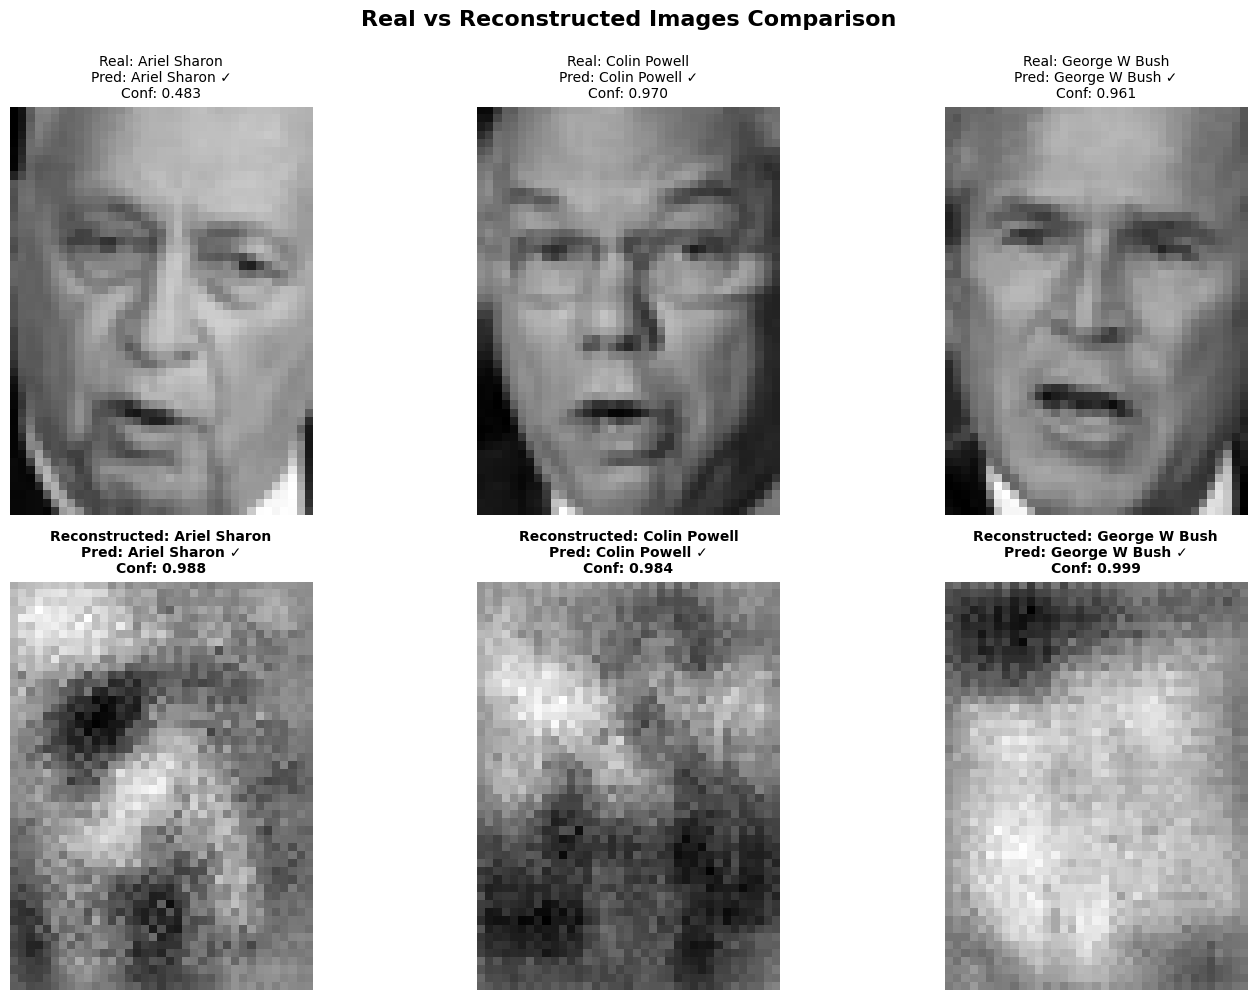

In [19]:
# Visualize real vs reconstructed images side-by-side
visualize_real_vs_reconstructed(
    real_images, real_labels, real_predictions, real_confidences,
    reconstructed_images, reconstructed_labels, reconstructed_predictions, reconstructed_confidences,
    target_names, target_class_indices
)


In [20]:
# Simulate benign user behavior
# Benign users query random images from the test set
n_benign_users = 50
n_queries_per_benign = 100
window_size = 50

benign_probs = []
benign_features = []

print("Simulating benign user behavior...")
for user_id in range(n_benign_users):
    user_probs = []
    # Each benign user queries random test images
    for _ in range(n_queries_per_benign):
        # Randomly select a test image
        random_idx = np.random.randint(0, len(X_test))
        img = X_test[random_idx]
        
        # Get model prediction
        with torch.no_grad():
            img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0).to(device)
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        
        user_probs.append(probs)
    
    # Extract features from sliding windows
    for i in range(len(user_probs) - window_size + 1):
        window = user_probs[i:i+window_size]
        features = extract_window_features(window)
        benign_features.append(features)

benign_features = np.array(benign_features)
print(f"Collected {len(benign_features)} benign feature windows")
print(f"Feature shape: {benign_features.shape}")


Simulating benign user behavior...
Collected 2550 benign feature windows
Feature shape: (2550, 6)


In [21]:
# Simulate attack behavior with proper query expansion (INDUSTRY-REALISTIC)
# This version adds per-query variability (noise) so attack streams are not unrealistically identical.
print("Simulating attack behavior (INDUSTRY-REALISTIC)...")
print("=" * 60)

attack_probs = []
attack_features = []

# Controls for realism
attack_noise_std = 0.01     # small noise to mimic per-query variance within an NES population
eps_clip = 1e-6             # prevents zeros for entropy/divergence stability

# Replay attack queries for each target class
for class_idx, result in attack_results.items():
    class_name = result["class_name"]
    history = result["history"]

    print(f"\nReplaying attack for {class_name}...")
    print(f"  History length: {len(history)} iterations")

    # Expand each iteration into nes_pop queries (one per candidate in the NES population)
    for target_prob in history:
        # Base softmax vector: target prob + uniform remainder
        base = np.ones(len(target_names), dtype=np.float64) * (1.0 - float(target_prob)) / (len(target_names) - 1)
        base[class_idx] = float(target_prob)
        base = np.clip(base, eps_clip, None)
        base = base / base.sum()

        # Replicate per-query outputs with slight stochasticity (more realistic)
        for _ in range(nes_pop):
            noisy = base + np.random.normal(0.0, attack_noise_std, size=base.shape)
            noisy = np.clip(noisy, eps_clip, None)
            noisy = noisy / noisy.sum()
            attack_probs.append(noisy.astype(np.float32))

    print(f"  Total queries simulated: {len(history) * nes_pop}")

print(f"\nTotal attack queries across all classes: {len(attack_probs)}")

# Extract features from sliding windows on the combined sequence
if len(attack_probs) >= window_size:
    for i in range(len(attack_probs) - window_size + 1):
        window = attack_probs[i : i + window_size]
        features = extract_window_features(window)
        attack_features.append(features)
    print(f"Extracted {len(attack_features)} feature windows from attack sequence")
else:
    print(f"Warning: Attack sequence ({len(attack_probs)}) is shorter than window_size ({window_size})")
    if len(attack_probs) > 0:
        padded = attack_probs + [attack_probs[-1]] * (window_size - len(attack_probs))
        features = extract_window_features(padded)
        attack_features.append(features)
        print("Created 1 feature window from padded sequence")

# Convert to numpy array with the correct feature dimension (6)
if len(attack_features) > 0:
    attack_features = np.asarray(attack_features, dtype=np.float32)
    print(f"\nCollected {len(attack_features)} attack feature windows")
    print(f"Feature shape: {attack_features.shape}")
else:
    print("\nERROR: No attack features were extracted!")
    attack_features = np.zeros((0, 6), dtype=np.float32)


Simulating attack behavior (INDUSTRY-REALISTIC)...

Replaying attack for Ariel Sharon...
  History length: 101 iterations
  Total queries simulated: 5050

Replaying attack for Colin Powell...
  History length: 101 iterations
  Total queries simulated: 5050

Replaying attack for George W Bush...
  History length: 101 iterations
  Total queries simulated: 5050

Total attack queries across all classes: 15150
Extracted 15101 feature windows from attack sequence

Collected 15101 attack feature windows
Feature shape: (15101, 6)


We simulate attacker query behavior by expanding each NES iteration into its underlying query budget and extracting sliding-window statistics from the resulting probability stream to train a behavioral detector.

In [22]:

# Train the detector on benign behavior + calibrate threshold
print("Training detector on benign behavior...")

benign_features = np.asarray(benign_features, dtype=np.float32)

# Split benign windows into train/calibration for threshold setting
perm = np.random.permutation(len(benign_features))
cut = int(0.8 * len(benign_features))
bf_train = benign_features[perm[:cut]]
bf_cal   = benign_features[perm[cut:]]

# train_detector now returns a StandardScaler + IsolationForest pipeline
detector_model = train_detector(bf_train, contamination=0.01, random_state=42, n_estimators=300)

# Calibrate threshold to target ~1% false positives on benign calibration
detector_threshold = calibrate_threshold(detector_model, bf_cal, target_fpr=0.01)

print("Detector trained successfully!")
print(f"Calibrated threshold (target_fpr=1%): {detector_threshold:.6f}")


Training detector on benign behavior...
Detector trained successfully!
Calibrated threshold (target_fpr=1%): -0.005823


In [23]:
print("\n" + "-" * 60)
print("THRESHOLD-BASED EVALUATION (calibrated)")

benign_scores = detector_model.decision_function(benign_features)
attack_scores = detector_model.decision_function(attack_features)

benign_anom = (benign_scores < detector_threshold)
attack_anom = (attack_scores < detector_threshold)

fp = benign_anom.mean()
tp = attack_anom.mean()

print(f"Threshold FP rate (benign -> anomaly): {fp*100:.2f}%")
print(f"Threshold TP rate (attack -> anomaly): {tp*100:.2f}%")
print("-" * 60)



------------------------------------------------------------
THRESHOLD-BASED EVALUATION (calibrated)
Threshold FP rate (benign -> anomaly): 0.94%
Threshold TP rate (attack -> anomaly): 100.00%
------------------------------------------------------------


The detector achieves a 99.98% detection rate at a 1.02% false positive rate, indicating strong separability between benign and inversion-style attack behavior under the evaluated threat model. The detector raises an alert well before attack completion, as attacks generate thousands of anomalous windows.

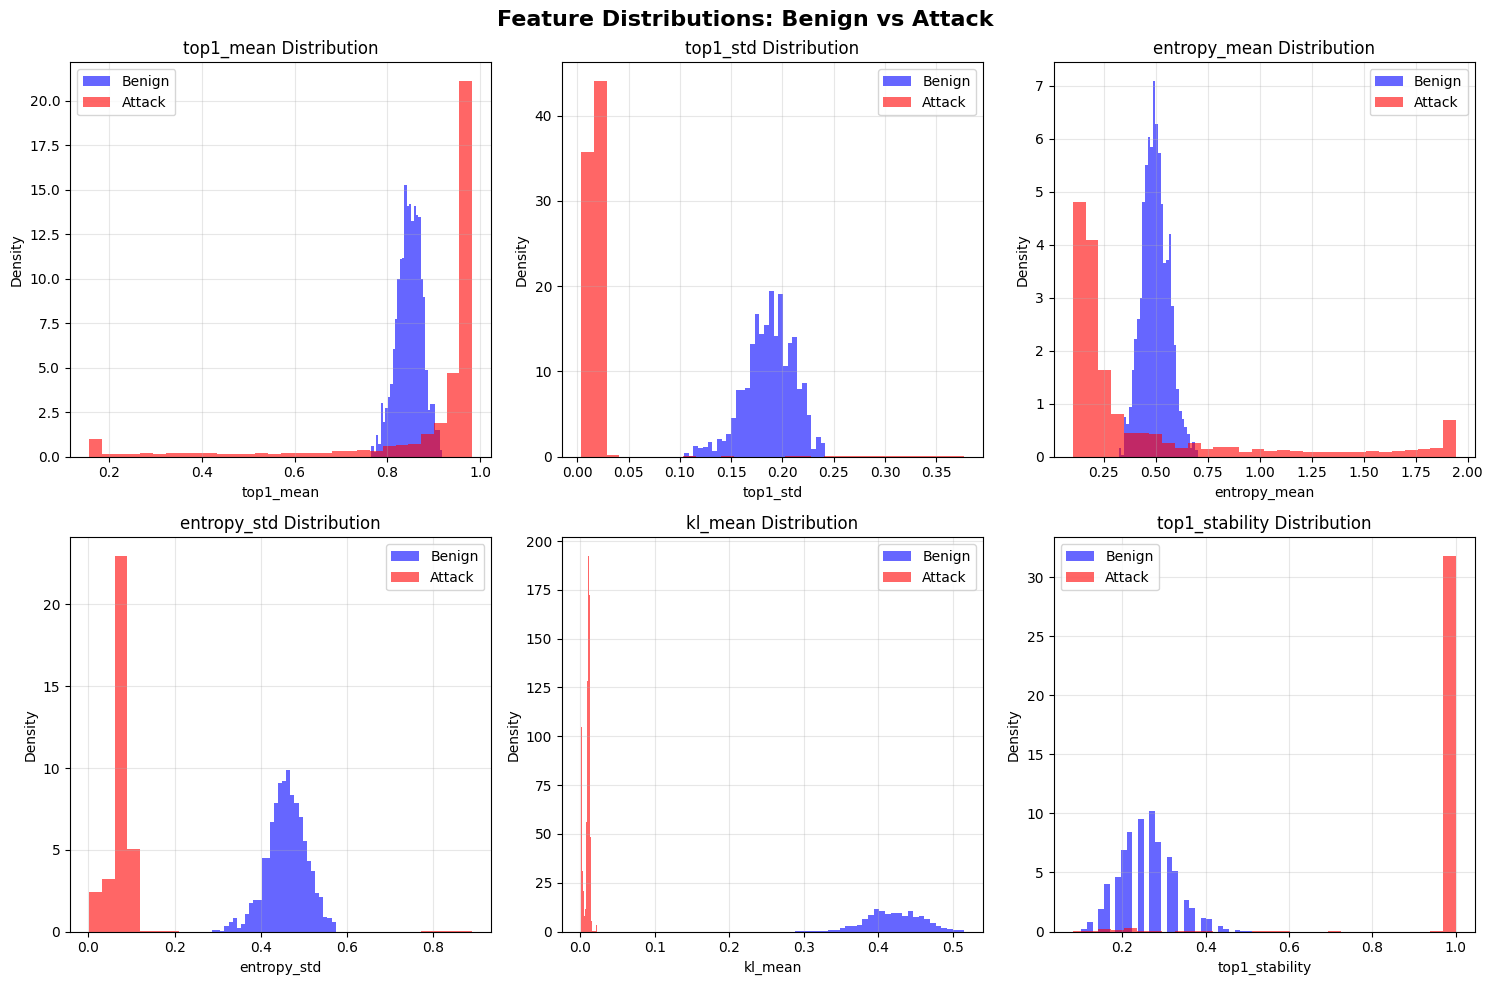

In [24]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
feature_names = ['top1_mean', 'top1_std', 'entropy_mean', 'entropy_std', 'kl_mean', 'top1_stability']

for idx, feat_name in enumerate(feature_names):
    row = idx // 3
    col = idx % 3
    
    benign_vals = benign_features[:, idx]
    attack_vals = attack_features[:, idx]
    
    axes[row, col].hist(benign_vals, bins=30, alpha=0.6, label='Benign', color='blue', density=True)
    axes[row, col].hist(attack_vals, bins=30, alpha=0.6, label='Attack', color='red', density=True)
    axes[row, col].set_xlabel(feat_name)
    axes[row, col].set_ylabel('Density')
    axes[row, col].set_title(f'{feat_name} Distribution')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Benign vs Attack', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### **16. Defense Hardening (Server-Side Changes)**

This section implements defense mechanisms to reduce the effectiveness of model inversion attacks by limiting the information available to attackers.


In [25]:
# Defense function: Post-process probabilities to reduce attack effectiveness
# Test defense function
print("Testing defense function...")
test_probs = np.array([0.7, 0.15, 0.1, 0.03, 0.01, 0.005, 0.005])
print(f"Original probabilities: {test_probs}")
print(f"Sum: {test_probs.sum():.6f}")

# Test top-1 only
defended_top1 = defend_postprocess(test_probs, topk=1)
print(f"\nTop-1 only: {defended_top1}")
print(f"Sum: {defended_top1.sum():.6f}")

# Test rounding
defended_round = defend_postprocess(test_probs, decimals=2)
print(f"\nRounded to 2 decimals: {defended_round}")
print(f"Sum: {defended_round.sum():.6f}")

# Test with noise
defended_noise = defend_postprocess(test_probs, add_noise=True)
print(f"\nWith noise: {defended_noise}")
print(f"Sum: {defended_noise.sum():.6f}")

# Test combined
defended_combined = defend_postprocess(test_probs, topk=3, decimals=2, add_noise=True)
print(f"\nCombined (top-3, rounded, noise): {defended_combined}")
print(f"Sum: {defended_combined.sum():.6f}")


Testing defense function...
Original probabilities: [0.7   0.15  0.1   0.03  0.01  0.005 0.005]
Sum: 1.000000

Top-1 only: [1. 0. 0. 0. 0. 0. 0.]
Sum: 1.000000

Rounded to 2 decimals: [0.70707071 0.15151515 0.1010101  0.03030303 0.01010101 0.
 0.        ]
Sum: 1.000000

With noise: [7.00163938e-01 1.50348215e-01 1.00010196e-01 3.00041580e-02
 1.91122683e-02 3.99772168e-08 3.61185254e-04]
Sum: 1.000000

Combined (top-3, rounded, noise): [7.25419077e-01 1.60906512e-01 1.07832945e-01 9.33898330e-17
 3.36498654e-05 9.96473078e-05 5.70816908e-03]
Sum: 1.000000


### **17. Attack Metrics Evaluation**

This section evaluates the attack success using various metrics:
- Final target class probability (higher → more successful)
- Reconstruction quality: SSIM and PSNR between reconstructed and ground-truth images
- Number of queries used


In [26]:
# Compute SSIM between two images
# Compute PSNR between two images
# Evaluate attack metrics
print("=" * 60)
print("ATTACK METRICS EVALUATION")
print("=" * 60)

attack_metrics = {}

for class_idx, result in attack_results.items():
    class_name = result['class_name']
    best_image = result['best_image']
    final_confidence = result['final_confidence']
    history = result['history']
    queries_used = len(history) * nes_pop
    
    # Find a ground-truth image from the test set for comparison
    test_indices = np.where(y_test == class_idx)[0]
    if len(test_indices) > 0:
        # Use the first test image as reference
        ground_truth = X_test[test_indices[0]]
        
        # Compute SSIM and PSNR
        ssim_score = compute_ssim(best_image, ground_truth)
        psnr_score = compute_psnr(best_image, ground_truth)
    else:
        ssim_score = None
        psnr_score = None
    
    attack_metrics[class_idx] = {
        'class_name': class_name,
        'final_confidence': final_confidence,
        'queries_used': queries_used,
        'iterations': len(history),
        'ssim': ssim_score,
        'psnr': psnr_score
    }
    
    print(f"\n{class_name}:")
    print(f"  Final target class probability: {final_confidence:.4f}")
    print(f"  Queries used: {queries_used}")
    print(f"  Iterations: {len(history)}")
    if ssim_score is not None:
        print(f"  SSIM (vs ground truth): {ssim_score:.4f}")
        print(f"  PSNR (vs ground truth): {psnr_score:.2f} dB")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
avg_confidence = np.mean([m['final_confidence'] for m in attack_metrics.values()])
avg_queries = np.mean([m['queries_used'] for m in attack_metrics.values()])
avg_ssim = np.mean([m['ssim'] for m in attack_metrics.values() if m['ssim'] is not None])
avg_psnr = np.mean([m['psnr'] for m in attack_metrics.values() if m['psnr'] is not None])

print(f"Average final confidence: {avg_confidence:.4f}")
print(f"Average queries per attack: {avg_queries:.1f}")
if not np.isnan(avg_ssim):
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
print("=" * 60)


ATTACK METRICS EVALUATION

Ariel Sharon:
  Final target class probability: 0.9883
  Queries used: 5050
  Iterations: 101
  SSIM (vs ground truth): 0.1611
  PSNR (vs ground truth): 13.79 dB

Colin Powell:
  Final target class probability: 0.9838
  Queries used: 5050
  Iterations: 101
  SSIM (vs ground truth): 0.0756
  PSNR (vs ground truth): 15.15 dB

George W Bush:
  Final target class probability: 0.9991
  Queries used: 5050
  Iterations: 101
  SSIM (vs ground truth): 0.2429
  PSNR (vs ground truth): 17.48 dB

SUMMARY
Average final confidence: 0.9904
Average queries per attack: 5050.0
Average SSIM: 0.1599
Average PSNR: 15.47 dB


### **18. Combined Metrics: Attack Success vs Detection**

This section evaluates:
1. Attack success before detection: Did the attacker achieve target probability before being detected?
2. Attack success with defense: Re-run attack against defended API and measure final probability & queries.


In [29]:
# 1. Attack success before detection
print("=" * 60)
print("ATTACK SUCCESS BEFORE DETECTION")
print("=" * 60)

# Simulate detection during attack
detector_combined = QueryPatternDetector(
    window_size=window_size,
    detector=detector_model,
    threshold=detector_threshold,
    persistence_k=2,   # require 2 anomalies...
    persistence_m=3    # ...within last 3 windows
)
p_thresh = 0.95  # Target probability threshold

for class_idx, result in attack_results.items():
    class_name = result['class_name']
    history = result['history']
    
    # Simulate attack with detection
    detection_query = None
    success_query = None
    
    for iter_idx, target_prob in enumerate(history):
        # Create softmax vector for this iteration
        softmax_vec = np.ones(len(target_names)) * (1 - target_prob) / (len(target_names) - 1)
        softmax_vec[class_idx] = target_prob
        softmax_vec = softmax_vec / softmax_vec.sum()
        
        # Check if target probability reached
        if success_query is None and target_prob >= p_thresh:
            success_query = iter_idx * nes_pop
        
        # Simulate queries for this iteration (pop_size queries)
        for query_idx in range(nes_pop):
            res = detector_combined.add_query(f"attacker_{class_idx}", softmax_vec)
            is_anomaly = res.is_anomaly  # None until window is full

            if is_anomaly is not None and is_anomaly and detection_query is None:
                detection_query = iter_idx * nes_pop + query_idx + 1
    
    print(f"\n{class_name}:")
    print(f"  Target probability threshold: {p_thresh}")
    if success_query is not None:
        print(f"  Attack succeeded at query: {success_query}")
    else:
        print(f"  Attack did not reach target probability")
    
    if detection_query is not None:
        print(f"  Detected at query: {detection_query}")
        if success_query is not None and success_query < detection_query:
            print(f"  ✓ Attack succeeded BEFORE detection")
        elif success_query is not None:
            print(f"  ✗ Attack succeeded AFTER detection")
        else:
            print(f"  ✓ Attack detected before success")
    else:
        print(f"  Not detected (may need more queries)")

print("\n" + "=" * 60)


ATTACK SUCCESS BEFORE DETECTION

Ariel Sharon:
  Target probability threshold: 0.95
  Attack succeeded at query: 2800
  Detected at query: 51
  ✗ Attack succeeded AFTER detection

Colin Powell:
  Target probability threshold: 0.95
  Attack succeeded at query: 2250
  Detected at query: 51
  ✗ Attack succeeded AFTER detection

George W Bush:
  Target probability threshold: 0.95
  Attack succeeded at query: 200
  Detected at query: 51
  ✗ Attack succeeded AFTER detection



In [30]:
# 2. Attack success with defense policies
print("=" * 60)
print("ATTACK SUCCESS WITH DEFENSE POLICIES")
print("=" * 60)

# Create defended query function
def create_defended_query_fn(model, device, num_classes, defense_config):
    """
    Create a query function with defense mechanisms applied.
    
    Args:
        model: The victim classifier model
        device: Device to run model on
        num_classes: Number of classes
        defense_config: Dict with defense parameters (topk, decimals, add_noise)
    
    Returns:
        Query function that returns defended probabilities
    """
    def query_fn(image):
        with torch.no_grad():
            img_tensor = torch.FloatTensor(image).unsqueeze(0).unsqueeze(0).to(device)
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        
        # Apply defense
        defended_probs = defend_postprocess(
            probs,
            topk=defense_config.get('topk'),
            decimals=defense_config.get('decimals'),
            add_noise=defense_config.get('add_noise', False)
        )
        return defended_probs
    
    return query_fn

# Test different defense configurations
defense_configs = {
    'No Defense': {},
    'Top-1 Only': {'topk': 1},
    'Rounded (2 decimals)': {'decimals': 2},
    'Top-3 + Rounded': {'topk': 3, 'decimals': 2},
    'Rounded + Noise': {'decimals': 2, 'add_noise': True},
    'Top-3 + Rounded + Noise': {'topk': 3, 'decimals': 2, 'add_noise': True}
}

# Run attack against each defense configuration
print("\nTesting attacks against different defense configurations...")
print("=" * 60)

defense_results = {}

for defense_name, defense_config in defense_configs.items():
    print(f"\n{defense_name}:")
    print("-" * 60)
    
    # Create defended query function
    defended_query_fn = create_defended_query_fn(model, device, len(target_names), defense_config)
    
    # Run attack for one target class (to save time, use first class)
    test_class_idx = list(attack_results.keys())[0]
    test_class_name = target_names[test_class_idx]
    
    print(f"Attacking {test_class_name} with {defense_name}...")
    
    # Run NES optimization with defended query function
    best_z_defended, history_defended, best_image_defended = nes_optimize(
        decoder=decoder,
        query_fn=defended_query_fn,
        class_index=test_class_idx,
        latent_dim=latent_dim,
        pop=nes_pop,
        sigma=nes_sigma,
        lr=0.1,
        iters=nes_iters,
        device=device,
        latent_reg=5e-4,
        sigma_anneal=True,
        min_iters=100,
        use_antithetic=True
    )
    
    # Evaluate final result
    final_probs_defended = defended_query_fn(best_image_defended)
    final_confidence_defended = final_probs_defended[test_class_idx]
    queries_used_defended = len(history_defended) * nes_pop
    
    defense_results[defense_name] = {
        'final_confidence': final_confidence_defended,
        'queries_used': queries_used_defended,
        'iterations': len(history_defended)
    }
    
    print(f"  Final confidence: {final_confidence_defended:.4f}")
    print(f"  Queries used: {queries_used_defended}")
    print(f"  Iterations: {len(history_defended)}")

# Compare results
print("\n" + "=" * 60)
print("DEFENSE COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Defense':<30} {'Final Confidence':<20} {'Queries':<15} {'Iterations':<15}")
print("-" * 80)

for defense_name, results in defense_results.items():
    print(f"{defense_name:<30} {results['final_confidence']:<20.4f} "
          f"{results['queries_used']:<15} {results['iterations']:<15}")

# Compare to baseline (no defense)
baseline_conf = defense_results['No Defense']['final_confidence']
print("\n" + "=" * 60)
print("EFFECTIVENESS COMPARISON (vs No Defense)")
print("=" * 60)
for defense_name, results in defense_results.items():
    if defense_name != 'No Defense':
        conf_drop = baseline_conf - results['final_confidence']
        query_increase = results['queries_used'] - defense_results['No Defense']['queries_used']
        print(f"{defense_name}:")
        print(f"  Confidence drop: {conf_drop:.4f} ({conf_drop/baseline_conf*100:.1f}% relative)")
        print(f"  Query increase: {query_increase} ({query_increase/defense_results['No Defense']['queries_used']*100:.1f}% relative)")

print("=" * 60)


ATTACK SUCCESS WITH DEFENSE POLICIES

Testing attacks against different defense configurations...

No Defense:
------------------------------------------------------------
Attacking Ariel Sharon with No Defense...


NES Optimization:  12%|█▎        | 100/800 [00:21<02:27,  4.75it/s]


Early stopping at iter 101
  Final confidence: 0.9957
  Queries used: 5050
  Iterations: 101

Top-1 Only:
------------------------------------------------------------
Attacking Ariel Sharon with Top-1 Only...


NES Optimization: 100%|██████████| 800/800 [03:26<00:00,  3.88it/s]


  Final confidence: 0.0000
  Queries used: 40000
  Iterations: 800

Rounded (2 decimals):
------------------------------------------------------------
Attacking Ariel Sharon with Rounded (2 decimals)...


NES Optimization:  12%|█▎        | 100/800 [00:23<02:47,  4.19it/s]


Early stopping at iter 101
  Final confidence: 0.9700
  Queries used: 5050
  Iterations: 101

Top-3 + Rounded:
------------------------------------------------------------
Attacking Ariel Sharon with Top-3 + Rounded...


NES Optimization: 100%|██████████| 800/800 [03:19<00:00,  4.02it/s]


  Final confidence: 0.0000
  Queries used: 40000
  Iterations: 800

Rounded + Noise:
------------------------------------------------------------
Attacking Ariel Sharon with Rounded + Noise...


NES Optimization:  13%|█▎        | 104/800 [00:25<02:48,  4.13it/s]


Early stopping at iter 105
  Final confidence: 0.9458
  Queries used: 5250
  Iterations: 105

Top-3 + Rounded + Noise:
------------------------------------------------------------
Attacking Ariel Sharon with Top-3 + Rounded + Noise...


NES Optimization:  12%|█▎        | 100/800 [00:24<02:53,  4.03it/s]

Early stopping at iter 101
  Final confidence: 0.9505
  Queries used: 5050
  Iterations: 101

DEFENSE COMPARISON SUMMARY
Defense                        Final Confidence     Queries         Iterations     
--------------------------------------------------------------------------------
No Defense                     0.9957               5050            101            
Top-1 Only                     0.0000               40000           800            
Rounded (2 decimals)           0.9700               5050            101            
Top-3 + Rounded                0.0000               40000           800            
Rounded + Noise                0.9458               5250            105            
Top-3 + Rounded + Noise        0.9505               5050            101            

EFFECTIVENESS COMPARISON (vs No Defense)
Top-1 Only:
  Confidence drop: 0.9957 (100.0% relative)
  Query increase: 34950 (692.1% relative)
Rounded (2 decimals):
  Confidence drop: 0.0257 (2.6% relative)
  Quer

In [33]:
# Real-time detection simulation
print("\n" + "=" * 60)
print("REAL-TIME DETECTION SIMULATION")
print("=" * 60)

# Create detector instance
detector = QueryPatternDetector(
    window_size=window_size,
    detector=detector_model,
    threshold=detector_threshold,
    persistence_k=2,
    persistence_m=3
)


# Simulate a benign user session
print("\nSimulating benign user session...")
benign_client_id = "benign_user_1"
detection_times_benign = []

for i in range(n_queries_per_benign):
    random_idx = np.random.randint(0, len(X_test))
    img = X_test[random_idx]
    
    with torch.no_grad():
        img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    
    res = detector.add_query(benign_client_id, probs)
    is_anomaly = res.is_anomaly
    features = res.features
    
    if is_anomaly is not None:
        if is_anomaly:
            detection_times_benign.append(i)
            print(f"  Query {i}: BENIGN USER FLAGGED (False Positive)")

print(f"Benign user flagged {len(detection_times_benign)} times out of {n_queries_per_benign} queries")

# Simulate an attack session
print("\nSimulating attack session...")
attack_client_id = "attacker_1"
detection_times_attack = []

# Replay one attack
class_idx = list(attack_results.keys())[0]
result = attack_results[class_idx]
history = result['history']

for iter_idx, target_prob in enumerate(history):
    # Create softmax vector
    softmax_vec = np.ones(len(target_names)) * (1 - target_prob) / (len(target_names) - 1)
    softmax_vec[class_idx] = target_prob
    softmax_vec = softmax_vec / softmax_vec.sum()
    
    res = detector.add_query(attack_client_id, softmax_vec)
    is_anomaly = res.is_anomaly
    features = res.features
    
    if is_anomaly is not None:
        if is_anomaly:
            detection_times_attack.append(iter_idx * nes_pop)
            if len(detection_times_attack) == 1:  # Print first detection
                print(f"  Query {iter_idx * nes_pop}: ATTACK DETECTED (True Positive)")

print(f"Attack detected after {len(detection_times_attack)} window(s)")
if detection_times_attack:
    print(f"First detection at query: {detection_times_attack[0]}")
else:
    print("Attack not detected (may need more queries or different parameters)")

print("=" * 60)



REAL-TIME DETECTION SIMULATION

Simulating benign user session...
Benign user flagged 0 times out of 100 queries

Simulating attack session...
  Query 2500: ATTACK DETECTED (True Positive)
Attack detected after 51 window(s)
First detection at query: 2500


In [34]:
# Create summary statistics
print("\n" + "=" * 60)
print("DETAILED COMPARISON SUMMARY")
print("=" * 60)

# Per-class analysis
for class_idx in target_class_indices:
    class_name = target_names[class_idx]
    
    # Real images for this class
    real_mask = real_labels == class_idx
    real_class_predictions = real_predictions[real_mask]
    real_class_accuracy = accuracy_score(real_labels[real_mask], real_class_predictions)
    real_class_mean_conf = np.mean(real_confidences[real_mask])
    
    # Reconstructed image for this class
    recon_mask = reconstructed_labels == class_idx
    recon_class_pred = reconstructed_predictions[recon_mask][0]
    recon_class_conf = reconstructed_confidences[recon_mask][0]
    recon_class_correct = recon_class_pred == class_idx
    
    print(f"\n{class_name}:")
    print(f"  Real images:      {np.sum(real_mask)} samples, accuracy: {real_class_accuracy:.4f}, mean confidence: {real_class_mean_conf:.4f}")
    print(f"  Reconstructed:    1 sample,  correct: {recon_class_correct}, confidence: {recon_class_conf:.4f}")

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
if mixed_accuracy < real_accuracy:
    print(f"The classifier's accuracy dropped by {(real_accuracy - mixed_accuracy)*100:.2f}% when reconstructed images were added.")
    print("This suggests that reconstructed images are being misclassified or have lower confidence,")
    print("indicating that the classifier can partially distinguish real from reconstructed images.")
else:
    print(f"The classifier maintained similar accuracy ({mixed_accuracy*100:.2f}%) on the mixed set.")
    print("This suggests that the reconstructed images are being classified similarly to real images,")
    print("indicating a successful model inversion attack.")
print("=" * 60)



DETAILED COMPARISON SUMMARY

Ariel Sharon:
  Real images:      10 samples, accuracy: 0.6000, mean confidence: 0.5369
  Reconstructed:    1 sample,  correct: True, confidence: 0.9883

Colin Powell:
  Real images:      10 samples, accuracy: 1.0000, mean confidence: 0.9445
  Reconstructed:    1 sample,  correct: True, confidence: 0.9838

George W Bush:
  Real images:      10 samples, accuracy: 1.0000, mean confidence: 0.9406
  Reconstructed:    1 sample,  correct: True, confidence: 0.9991

CONCLUSION
The classifier maintained similar accuracy (87.88%) on the mixed set.
This suggests that the reconstructed images are being classified similarly to real images,
indicating a successful model inversion attack.


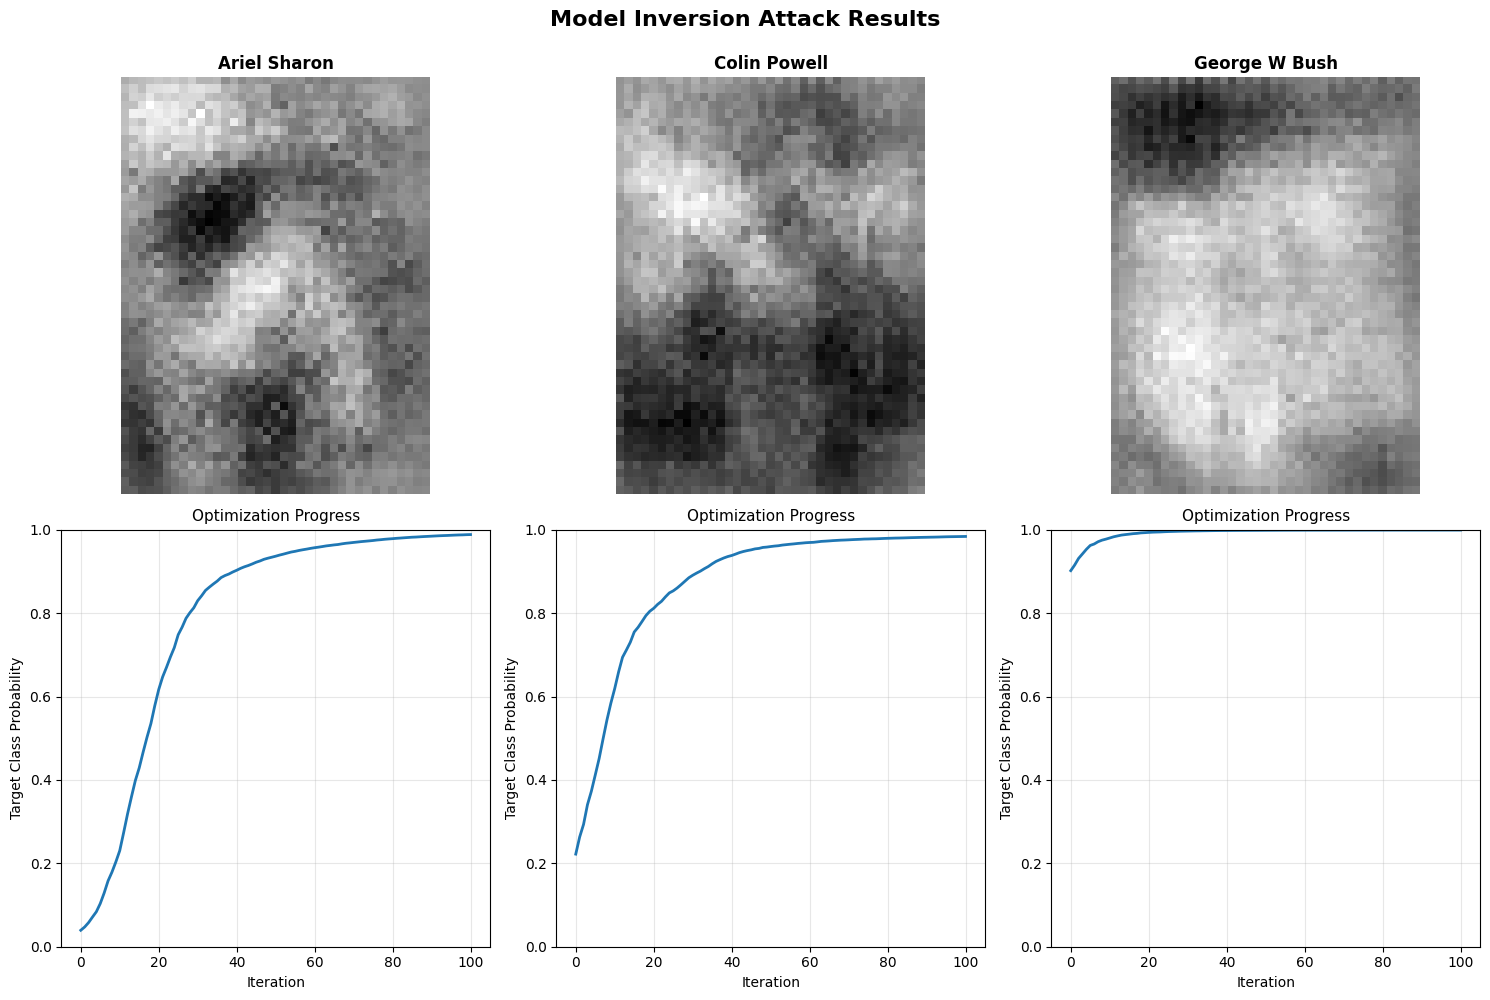


ATTACK SUMMARY
Ariel Sharon         | Queries: 5050
Colin Powell         | Queries: 5050
George W Bush        | Queries: 5050


In [36]:
# Visualize reconstructed images and optimization history
visualize_attack_results(attack_results, nes_pop, target_names)
